# Non-Linear System of Equations Solved with Mousai
#### By: Austin McDonnell

## Importing Necessary Packages
The first of these packages that are needed to solve this project is matplotlib. The matplotlib package provides a plotting framework that is very similar to that of MATLAB; were pylab combines pyplot and numpy into one package. Importing matplotlib.pyplot is where various states are preserved across function calls, so that it keeps track of things like the current figure and plotting area. The first three lines of the importing packages section is what is considered magic commands. The first sets up IPython to work correctly with matplotlib and including inline makes it so the output plot is displayed inline with the code, basically the plot will be directly after the code that produces it and will be saved to the notebook. The next two lines makes it so that IPython reloads the modules before executing the user code; using autoreload 2 makes it that the modules reload everytime before executing the code. The last line of this section makes sure that the figure is set up to the parameters given. The next package that is imported is the numpy package; which provides fast and efficient operations on arrays of homogeneous data, extends Python into a high-level language for manipulating numerical data. The last of these packages that was imported, mousai, is the reason to do this project. Mousai is a harmonic balance code to solve a wide arrary of problems that are presented as non-linear ordinary differntial equations(ODEs) and there solutions can be represented by Fourier Series.


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mousai as ms
matplotlib.rcParams['figure.figsize']=(11,5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating the Function (nls_ms)
In order to use the imported package mousai to solve the system of equations a function must be defined; for this project the function is nls_ms. In this function the parameters will be defined and the system of equations is put into its state space form. The first of these parameters is t, this is a necessary parameter because the derivatives to be solved are time derivatives. If the t parameter is left out the Mousai function hb_time will be unable to solve the problem completely. The next five parameters are all variables that are a part of the system of equations being solved for. These parameters must be defined in the function set up so that they exist before the system is put into the state space form; they are later defined in the hb_time function. The system of equations, shown below in the image, that is used is taken from the paper Non-Linear Normal Modes(NNMs) and Their Applications in Vibration Theory: An Overview by A.F. Vakakis.
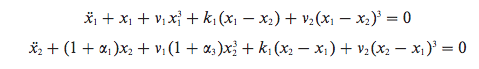
NNMs can be used as a valuable tool for understanding some essentially non-linear dynamic phenomena, that don't really have a linear counterpart to analyze it. Applications of NNMs to modal analysis model reduction, vibration and shock isolation design and the theory of non-linear oscillators. NNMs are non-similar and difficult to compute; which is why mousai will be very usefull for computing this system of equations. This particular system of equations is a non-similar NNM with non-symmetric grounding stiffnesses. The first of the parameters are nu1 and nu2 are non-linear stiffness terms, nu1 is the grounding stiffness and nu2 is the coupling stiffness. The next of these parameters is k a coupling coefficient. The last two parameters, alpha1 and alpha3 are mistuning parameters that will adjust the asymmetry of the system. For this particular problem it will be assumed that ther is weak coupling; which means that the parameters nu2 and k are going to be much smaller than 1. For mousai to more easily interprut the system of equations it is put into the state space form. State space re-arranges the second order system of equations and makes them into a first order differential equations which become easier to solve. 

In [6]:
def nls_ms(x,params):
    t = params['cur_time']
    nu1 = params['nu1']
    nu2 = params['nu2']
    k = params['k']
    alpha1 = params['alpha1']
    alpha3 = params['alpha3']
    #x[1]=x1dd, x[0]=x1, x[2]=x2, x[3]=x2dd
    xd = np.array([[x[1]],
                   [-x[0]-nu1*x[0]**3-k*(x[0]-x[2])-nu2*(x[0]-x[2])**3],
                   [x[3]],
                   [-(1-alpha1)*x[2]-nu1*(1+alpha3)*x[2]**3
                    -k*(x[2]-x[0])-nu2*(x[2]-x[0])**3]])
    return xd

## Using Mousai
Mousai, written by Dr. Joesph Slater, was written in order to implement harmonic balance into a wide array of problems that are represented by non-linear ordinary differential equations. To solve the system defined earlier the built in function in Mousai hb_time is used; which is occupied with the necessary information. Hb_time obtains the solution of either a first or second order differential equation using the presumption that the solution is harmonic using an algebraic time method. The results that are output are time, displacement, velocity, and acceleration. The necesary parameters that are put into hb_time, for this particular project, are the function name, in this case nls_ms. The second input parameter is an array, x0, which is being used as an initial condition array to jump start the solution. Next is defining the number of harmonics that are presumed, this number is based off the number columns in the x0 array. The fourth input parameter is the number of variables that are in the equation that is being solved, in this case there are four variables in the system of equation being solved. The next input parameter is eqform, which asks how the equation is formed, either first or second order. In this project even though it is a second order differential system of equations it was put into the state space form; which means that it can be solved as a first order. The last of the input parameters is dictionary of parameters that are being put into the system to be solved. The next built in Mousai funtion that is used in this project to plot the output from hb_time, is time_history. This function generates a refined time history from the harmonic balance solution; this function fills in the gaps using the harmonics obtained in the solution. This function's input parameters are the outputs from hb_time, t (time) and x (displacement), and it outputs an array of time that fills the gap between the answers and a displacement arrary that again fills in the gaps between the previously solved for answers. When looking at the set up of the plot that shows the displacement and velocity the first two inputs are the new found time and displacement solved for by time_history and the second two inputs are the time and displacement solved for by hb_time. Using both of these solutions allows for a graph to show a smooth and continuous plot of the responses.

In [7]:
#Initial Conditions-> x1(0)=X1, x1d(0)=0, x2(0)=X2, x2d(0)=0
a = np.array([[1],[0],[1],[0]])
t,x,e,amps,phases = ms.hb_time(nls_ms,x0=a, num_harmonics=2, num_variables=4, eqform='first_order', params={'nu1':1,'nu2':0.05,'k':0.05,'alpha1':1,'alpha3':1})

amps


array([ 0.00600432,  0.00600432,  0.0044674 ,  0.0044674 ])

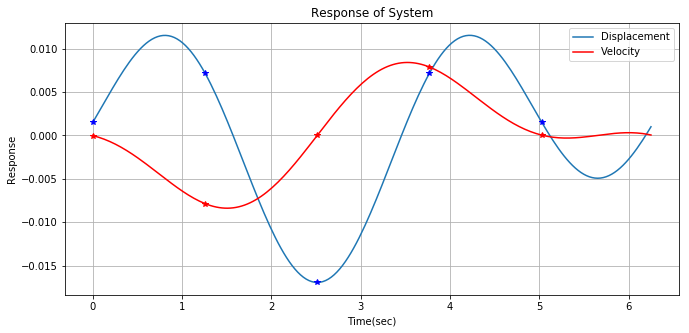

In [8]:
time, xc = ms.time_history(t,x)
disp_plot,_=plt.plot(time,xc.T[:,0],t,x.T[:,0],'*b', label='Displacement')
vel_plot,_=plt.plot(time, xc.T[:,1], 'r',t, x.T[:,1], '*r', label='Velocity')
plt.legend(handles=[disp_plot,vel_plot])
plt.xlabel('Time(sec)')
plt.ylabel('Response')
plt.title('Response of System')
plt.legend
plt.grid(True)

Explanation of the plot